# Navigation

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.30 which is incompatible.
jupyter-console 6.4.3 has requirement jupyter-client>=7.0.0, but you'll have jupyter-client 5.2.4 which is incompatible.


The environment is already saved in the Workspace and can be accessed at the file path provided below.  Please run the next code cell without making any changes.

In [2]:
from unityagents import UnityEnvironment
import numpy as np

# please do not modify the line below
env = UnityEnvironment(file_name="/data/Banana_Linux_NoVis/Banana.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [ 1.          0.          0.          0.          0.84408134  0.          0.
  1.          0.          0.0748472   0.          1.          0.          0.
  0.25755     1.          0.          0.          0.          0.74177343
  0.          1.          0.          0.          0.25854847  0.          0.
  1.          0.          0.09355672  0.          1.          0.          0.
  0.31969345  0.          0.        ]
States have length: 37


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agent while it is training**, and you should set `train_mode=True` to restart the environment.

In [5]:
env_info = env.reset(train_mode=True)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = np.random.randint(action_size)        # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: 0.0


When finished, you can close the environment.

In [ ]:
# env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agent while it is training.  However, **_after training the agent_**, you can download the saved model weights to watch the agent on your own machine! 

### 5. Build model

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
from collections import deque, namedtuple
import matplotlib.pyplot as plt

class DQNetwork(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, 
                 fc1_dims = 64, fc2_dims = 64, fc3_dims = 64, lr = 0.001):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_dims (int): Number of nodes in first hidden layer
            fc2_dims (int): Number of nodes in second hidden layer
            fc3_dims (int): Number of nodes in 3rd hidden layer
            lr (float): learning rate
        """
        super(DQNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_dims)
        self.fc2 = nn.Linear(fc1_dims, fc2_dims)
        self.fc3 = nn.Linear(fc2_dims, fc3_dims)
        self.fc4 = nn.Linear(fc3_dims, action_size)
        
        self.optimizer =  optim.Adam(self.parameters(), lr= lr)
        self.loss = torch.nn.MSELoss()


    def forward(self, state):
        """Build a network that maps state -> action values."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)


In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Agent():
    """Interacts with and learns from the environment."""
    def __init__(self, state_size, action_size, seed = 1201, lr = 0.0001, gamma = 0.99, epsilon = 1.0, 
                 eps_dec = 1e-5, eps_min = 0.01, buffer_size = 10000, batch_size = 32, update = 4, tau = 0.01):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """
        
        self.seed = random.seed(seed)
        self.lr = lr
        self.gamma = gamma
        self.action_size = action_size
        self.epsilon = epsilon
        self.eps_min   = eps_min
        self.eps_dec   = eps_dec
        self.buffer_size = buffer_size
        self.batch_size = batch_size
        self.update = update
        self.action_space = [ i for i in range(action_size)]
        self.tau = tau
        
        # Q-Network
        self.qnetwork_local = DQNetwork(state_size, action_size, seed,
                                    fc1_dims = 64, fc2_dims = 64, fc3_dims = 64, lr = lr).to(device)
        self.qnetwork_target = DQNetwork(state_size, action_size, seed, 
                                    fc1_dims = 64, fc2_dims = 64, fc3_dims = 64, lr = lr).to(device)
        

        # Replay memory
        self.memory = ReplayBuffer(action_size, buffer_size, batch_size, seed)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0
        
        
    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)
        
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % self.update
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > self.batch_size:
                experiences = self.memory.sample()
                self.learn(experiences)

    def choose_action(self, state):
        """Returns actions for given state as per current policy.
        
        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        # Epsilon-greedy action selection
        if random.random() > self.epsilon:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences):
        """Update value parameters using given batch of experience tuples.

        Params
        ======
            experiences (Tuple[torch.Variable]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # Get max predicted Q values (for next states) from target model
        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        
        
        # Compute Q targets for current states 
        Q_targets = rewards + (self.gamma * Q_targets_next * (1 - dones))

        # Get expected Q values from local model
        Q_expected = self.qnetwork_local(states).gather(1, actions)

        # Compute loss
        loss = self.qnetwork_local.loss(Q_expected, Q_targets)
        # Minimize the loss
        self.qnetwork_local.optimizer.zero_grad()
        loss.backward()
        self.qnetwork_local.optimizer.step()
        
                # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target)                     

    def soft_update(self, local_model, target_model):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(self.tau*local_param.data + (1.0-self.tau)*target_param.data)
            
            

In [18]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [19]:
def plot_learning_curve(x, scores, epsilons, filename ="learning_curve.png"):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

    fig.suptitle('DQLearning', fontsize=14)
    ax1.plot(x, epsilons)
    # ax1.set_xlabels("Training step", color ='C0')
    ax1.set_ylabel('Epsilon', fontsize=12)
    ax1.tick_params( axis = 'x', color = 'C0')
    ax1.tick_params( axis = 'y', color = 'C0')

    N = len(scores)
    running_avg = np.empty(N)
    for t in range(N):
        running_avg [t] = np.mean(scores[max(0, t-100):(t+1)])
        
        
    ax2.plot(x, running_avg)
    ax2.set_ylabel('Score', fontsize=12)
    ax2.tick_params( axis = 'x', color = 'C0')
    ax2.tick_params( axis = 'y', color = 'C0')
    fig.text(0.5, 0.04, 'Training Step', ha='center', va='center')
#     plt.savefig(filename)


Episode 0	Average Score: 1.00
Episode 100	Average Score: 5.66
Episode 200	Average Score: 11.06
Episode 300	Average Score: 10.93
Episode 400	Average Score: 11.77
Episode 500	Average Score: 13.45
Episode 600	Average Score: 13.08
Episode 700	Average Score: 13.24
Episode 800	Average Score: 13.64
Episode 900	Average Score: 13.77
Episode 999	Average Score: 13.85

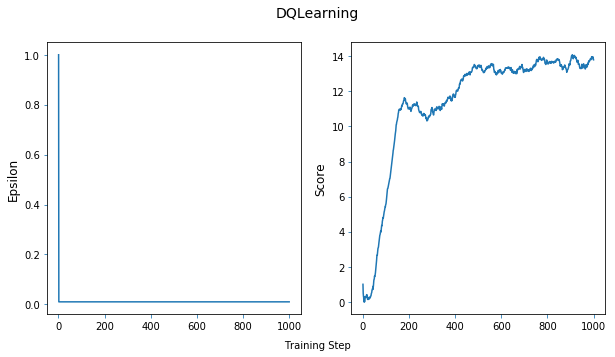

In [27]:
from unityagents import UnityEnvironment

# if __name__ == '__main__':
    # load Unity enviroment 
    
#     env = UnityEnvironment(file_name="/data/Banana_Linux_NoVis/Banana.x86_64")
    
    # get the default brain
#     brain_name = env.brain_names[0]
#     brain = env.brains[brain_name]
#     env_info = env.reset(train_mode=True)[brain_name]

scores, eps_history = [], []
n_games = 1000

agent = Agent(state_size = len(env_info.vector_observations[0]),
              action_size= brain.vector_action_space_size, 
              seed= 0)

for i in range(n_games):
    env_info = env.reset(train_mode=True)[brain_name] # reset the environment
    state = env_info.vector_observations[0]    

    score = 0
    done = False


    while not done:
        action = agent.choose_action(state)

        env_info = env.step(action)[brain_name]        # send the action to the environment
        next_state = env_info.vector_observations[0]   # get the next state
        reward = env_info.rewards[0]                   # get the reward
        done = env_info.local_done[0]

        agent.step(state, action, reward, next_state, done)
        state = next_state
        score += reward

    scores.append(score)              # save most recent score
    eps_history.append(agent.epsilon)
    agent.epsilon = max(agent.eps_min, agent.eps_dec*agent.epsilon) # decrease epsilon
    
    
    avg_score = np.mean(scores[-100:])    
    print('\rEpisode {}\tAverage Score: {:.2f}'.format(i, avg_score), end="")

    if i % 100 == 0:
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i, avg_score))

#         if avg_score >= 13.0:
#             print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, avg_score))
#             torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
#             break
x = [i+1 for i in range(n_games)]
plot_learning_curve(x, scores, eps_history)    
# env.close()

In [28]:
torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')